In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as mtick
from matplotlib import cm
from scipy.signal import argrelextrema
import scipy.optimize as opt

# for matplotlib backends see: https://matplotlib.org/stable/users/explain/backends.html
# WHEN CHANGING MATPLOTLIB BACKEND, RESTART THE KERNEL

# use inline for basic inline graphs, but no animations
%matplotlib inline

# use widget for inline animations
# %matplotlib widget

# use qt for interactive pop up windows of graphs --> must restart kernel
# import matplotlib
# matplotlib.use('QtAgg')
# %matplotlib qt

### Define conversion factors from phyiscal to non-dimensionalized lattice units

In [ ]:
# set conversion factors so that delta_x_star = delta_t_star = delta_rho_star = 1
def get_conversion_factors(physical_distance_between_simulation_nodes, physical_duration_time_step, physiscal_averaged_density_rho0):
    conversion_factor_length = physical_distance_between_simulation_nodes
    conversion_factor_time = physical_duration_time_step
    conversion_factor_density = physiscal_averaged_density_rho0

    conversion_factor_velocity = conversion_factor_length / conversion_factor_time
    conversion_factor_force = conversion_factor_density * conversion_factor_length**4 * conversion_factor_time**(-2) 
    conversion_factor_frequency = 1 / conversion_factor_time

    conversion_factors = {
        'length': conversion_factor_length,
        'time': conversion_factor_time,
        'density': conversion_factor_density,
        'velocity': conversion_factor_velocity,
        'force': conversion_factor_force,
        'frequency': conversion_factor_frequency
    }

    return conversion_factors

### Define physical properties

#### Simple initialization without physical base 

In [ ]:
def simple_initialization(lattice_size_x = 15, lattice_size_y = 10, reynolds_number=1000):
    """
    Initialization without physical base
    All variables are directly defined in lattice units
    """
    distance_between_nodes = 1
    rho0 = 1.
    delta_time = 1.
    tau_star = 0.6
    conversion_factors = get_conversion_factors(distance_between_nodes, delta_time, rho0)
    

    return lattice_size_x, lattice_size_y, rho0, reynolds_number, tau_star, conversion_factors

#### Initialize properties for poiseuille flow

In [ ]:
def init_poiseuille_flow():
    """
    Variables with star are simulation variables that are dimensionless
    """
    # size of the lattice in y direction in meter (= D). This is the characteristic length in the reynolds number
    D = 1e-3
    # size of the lattice in x direction in meter
    L = 1
    # pressure difference between inlet and outlet [in pascal]
    delta_p = 1e-2
    # kinematic phyiscal viscosity
    viscosity = 1e-6
    # initial physical average density
    rho0 = 1e3

    # number of discretized points of simulation in y direction
    D_star = 100
    # distance between two lattice nodes in meter
    physical_distance_between_simulation_nodes = D / D_star
    # print in scientific notation
    print("Physical distance between simulation nodes: {:.2e}".format(physical_distance_between_simulation_nodes))
    lattice_size_x = L / physical_distance_between_simulation_nodes
    lattice_size_y = D_star


    physical_u_center_line = 1/8 * (rho0 / viscosity) * (delta_p / L) * D**2    # physical max velocity

    reynolds_number = physical_u_center_line * D / viscosity

    u_center_line_star = 0.1
    viscosity_star = u_center_line_star * D_star / reynolds_number
    print("VISCOSITY STAR {:.2e}".format(viscosity_star))
    # speed_of_sound_star = 1 / np.sqrt(3)
    speed_of_sound_squared_star = 1 / 3
    tau_star = (1/speed_of_sound_squared_star) * viscosity_star + 0.5
    # physical_distance_between_simulation_nodes = 5e-5
    conversion_factor_time = speed_of_sound_squared_star * (tau_star - 0.5) * physical_distance_between_simulation_nodes**2 / viscosity
    print("CONVERSION FACTOR TIME {}".format(conversion_factor_time))
    print("TAU STAR {}".format(tau_star))

    conversion_factors = get_conversion_factors(physical_distance_between_simulation_nodes, conversion_factor_time, rho0)
    rho0_star = rho0 / conversion_factors['density']

    return lattice_size_x, lattice_size_y, rho0_star, reynolds_number, tau_star, conversion_factors
    

### Calculate lattice constants in lattice units

In [ ]:
# TODO: Check if simple initialization is necessary/makes sense
# grid_size_x, grid_size_y, rho0, reynolds_number, tau_star, conversion_factors =  simple_initialization()
# # grid_size_x, grid_size_y, rho0, reynolds_number, tau_star, conversion_factors = init_poiseuille_flow()
# grid_values_count = grid_size_x * grid_size_y
# omega = 1 / tau_star


### Intialize arrays

In [ ]:
# arrays defined in format y,x which is row, column if not stated differently

# Velocity directions c (defined by [x,y] components)
c_directions = np.array([
                [ 0, 0], # 0 ()
                [ 1, 0], # 1 (right)
                [ 0, 1], # 2 (up)
                [-1, 0], # 3 (left)
                [ 0,-1], # 4 (down)
                [ 1, 1], # 5 (right-up)
                [-1, 1], # 6 (left-up)
                [-1,-1], # 7 (left-down)
                [ 1,-1]  # 8 (right-down)
             ])

# indices: i = discretized velocity index (0-8), y = row, x = column
# f_values_iyx = np.zeros((9, grid_size_y, grid_size_x))
omega_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

#### Different density initializations

In [ ]:
# evenly distribute density in all directions for all grid points
# rho0 = 0.8
# omega = 0.1
# impurity_density = 0.1 * rho0
# initial_equal_density_per_position = (rho0-impurity_density) / float(grid_values_count-1) 
# f_values_iyx = np.full((9, grid_size_y, grid_size_x), initial_equal_density_per_position / 9.)

# # # add one impurity at center
# f_values_iyx[:,5,7] = impurity_density / 9.

In [ ]:
# calculate a "border", which is a vertical line, that seperates two directions
# this enables an initialization which can be used for a quick visual check of the streaming function
# inital_border_value = np.rint(grid_size_x/2).astype(np.uint8)
# initial_equal_density_per_position = rho0 / float(grid_values_count) 
# f_values_iyx[5, :, inital_border_value:] = initial_equal_density_per_position * 1/4
# f_values_iyx[1, :, 0:inital_border_value] = initial_equal_density_per_position * 3/4
# f_values_iyx[1,:,:] = initial_equal_density_per_position

### Functions

##### Density function

In [ ]:
def compute_density_field(f_values_iyx):
    """
    Computes the density field rho for a given f_values_iyx array.
    
    Parameters:
        f_values_iyx: Array of f values with shape (9, grid_size_y, grid_size_x)

    Returns:
        Array of density values with shape (grid_size_y, grid_size_x)
    """
    return np.sum(f_values_iyx, axis=0)

#### Velocity field function

In [ ]:
def calc_density_and_average_velocity(f_values_iyx):
    """
    Calculates the density and average velocity field for a given f_values_iyx array.

    Parameters
    ----------
        f_values_iyx: Array of f values with shape (9, grid_size_y, grid_size_x)

    Returns
    -------
        density_values_yx: Array of density values with shape (grid_size_y, grid_size_x)
        average_velocity_field_directions_yxc: Array of average velocity directions with shape (grid_size_y, grid_size_x, 2)

        average_velocity_field_directions_yxc contains a velocity direction for every position and is given element-wise for cartesian coordinates
    """

    # calculate current density
    density_values_yx = compute_density_field(f_values_iyx)

    # do: [:,np.newaxis] so that broadcasting works
    # multiply every element of f_values_iyx with it respective direction given by index i and then sum over all directions for a position jk
    # the resulting array has shape (y,x,2) and contains a velocity direction for every position and is divided by the respective density
    # indices: y = row, x = column, c = cartesian coordinates of respective velocity at position given in format [x,y]
    average_velocity_field_directions_yxc = np.divide(np.einsum("ijk, il->jkl", f_values_iyx, c_directions), density_values_yx[..., np.newaxis])
 
    return density_values_yx, average_velocity_field_directions_yxc


#### Equilibrium distribution and collision term

In [ ]:
def equilibrium_distribution(density_values_yx, u_yxc, velocity_zero = False):
    """
    Calculates the equilibrium distribution for a given density and average velocity field.

    Parameters
    ----------
        density_values_yx: Array of density values
        u_yxc: Array of average velocity directions with shape (grid_size_y, grid_size_x, 2)

    Returns
    -------
        Array of equilibrium distribution values with shape (9, grid_size_y, grid_size_x)
    """

    f_eq_iyx = None

    # calculate equilibrium distribution
    if velocity_zero:
        f_eq_iyx = np.einsum('i,jk->ijk', omega_i, density_values_yx)
    else:
        # precompute terms for equilibrium distribution
        u_norm_squared_yx = np.einsum("yxc, yxc -> yx", u_yxc, u_yxc)
        uc_yx = np.einsum("yxc, ic -> iyx", u_yxc, c_directions)
        f_eq_iyx = np.einsum('i,jk->ijk', omega_i, density_values_yx) * (1 + 3 * uc_yx + 4.5 * uc_yx**2 - 1.5 * u_norm_squared_yx)

    return f_eq_iyx

In [ ]:
# u is the average velocity
# yx describes row, column
# c is cartesian coordinates [xy]
# i is the velocity discretization[0..8] <-- 9 values
def collide(f_values_iyx, density_values_yx, u_yxc, omega):
    """
    Calculates the collision term for a given f_values_iyx array.

    Parameters
    ----------
        f_values_iyx: Array of f values with shape (9, grid_size_y, grid_size_x)
        density_values_yx: Array of density values
        u_yxc: Array of average velocity directions with shape (grid_size_y, grid_size_x, 2)

    Returns
    -------
        Updated array of f values after the collision step with shape (9, grid_size_y, grid_size_x)
    """
    f_eq_iyx = equilibrium_distribution(density_values_yx, u_yxc)
    # return updated f values after collision
    return  (1-omega) * f_values_iyx + omega * f_eq_iyx


#### Streaming Function

In [ ]:
def streaming(f_values_iyx):  
    """
    Calculates the streaming step for a given f_values_iyx array and boundary handling type.

    Parameters
    ----------
        f_values_iyx: Array of f values with shape (9, grid_size_y, grid_size_x)

    Returns
    -------
        Updated array of f values after the streaming step with shape (9, grid_size_y, grid_size_x)
    """    
    # start at index 1 because direction 0 (0,0) does not change anything with roll call, axis=(1,0) means first in x direction, then in y direction because f is defined by row, col (y,x) indices 
    for i in range(1, len(c_directions)): f_values_iyx[i] = np.roll(f_values_iyx[i], shift=c_directions[i], axis=(1,0))
    return f_values_iyx

#### Boundary conditions

In [ ]:
# velocity at boundary is zero
# additional nodes outside of grid: f = np.array((9, nx + 2, ny + 2)) CARE ORDER NX AND NY (one at top and one at bottom --> = 2)
# add padding layer of nodes for every of the 9 directions

# 1. streaming --> also write to outside nodes
# 2. bounce back (for top boundary: # f 5 to 7, 2 to 4, 6 to 8) and clear outside nodes
# 3. ...


def bounce_back_boundary(f_values_iyx):
    pass

#### Update function that handles going to next time step

In [ ]:
def update(f_values_iyx, density_values_yx, average_velocity_field_directions_yxc, omega):
    """
    Calculates updated f_values_iyx for a given f_values_iyx array.

    Parameters
    ----------
        f_values_iyx: Array of f values with shape (9, grid_size_y, grid_size_x)
        density_values_yx: Array of density values
        average_velocity_field_directions_yxc: Array of average velocity directions with shape (grid_size_y, grid_size_x, 2)

    Returns
    -------
        Updated array of f values after the streaming and collision step with shape (9, grid_size_y, grid_size_x)
        Updated array of density values with shape (grid_size_y, grid_size_x)
        Updated array of average velocity directions with shape (grid_size_y, grid_size_x, 2)
    """

    f_values_iyx = streaming(f_values_iyx)
    # f_values_iyx = bounce_back(f_values_iyx)
    density_values_yx, average_velocity_field_directions_yxc = calc_density_and_average_velocity(f_values_iyx)
    f_values_iyx = collide(f_values_iyx, density_values_yx, average_velocity_field_directions_yxc, omega)
    density_values_yx, average_velocity_field_directions_yxc = calc_density_and_average_velocity(f_values_iyx)

    return f_values_iyx, density_values_yx, average_velocity_field_directions_yxc

In [ ]:
def calc_max_velocity_magnitude(average_velocity_field_directions_yxc):
    """
    Calculates the maximum velocity magnitude for a given average_velocity_field_directions_yxc array.

    Parameters
    ----------
        average_velocity_field_directions_yxc: Array of average velocity directions with shape (grid_size_y, grid_size_x, 2)

    Returns
    -------
        Maximum velocity magnitude
    """
    # calculate magnitude of velocity vectors
    velocity_magnitude_yx = np.linalg.norm(average_velocity_field_directions_yxc, axis=2)
    max_velocity_magnitude = np.max(velocity_magnitude_yx)
    return max_velocity_magnitude

### Visualization

#### Density plot

In [ ]:
def plot_grid_datafield(grid_data_values_yx ,timestep = None, label="Density"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x_dim = grid_data_values_yx.shape[1]
    y_dim = grid_data_values_yx.shape[0]
    x,y = np.meshgrid(np.arange(x_dim), np.arange(y_dim))

    ax.plot_surface(x, y, grid_data_values_yx)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(label)
    title = label + " field"
    if timestep is not None:
        title += " for t={}".format(timestep)
    ax.set_title(title)

    plt.show()

#### Velocity field plot

In [ ]:
# plot velocity streamlines and plot average velocity y component over time on grid
def plot_velocity_field(velocity_field_yxc, timestep : int = 0):

    grid_size_y = velocity_field_yxc.shape[0]
    grid_size_x = velocity_field_yxc.shape[1]
    # define grid of velocity field
    x = np.arange(grid_size_x)
    y = np.arange(grid_size_y)

    X, Y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')

    # velocity x direction
    U = velocity_field_yxc[:,:,0]
    # velocity y direction
    V = velocity_field_yxc[:,:,1]

    # normalize when using quiver --> use quiver for exakt representation of velocity directions
    # U = np.sign(U)
    # V = np.sign(V)
    # ax.quiver(X, Y, U, V, scale=1, units='xy', angles="xy", scale_units="xy") #is also a good option

    stream = ax.streamplot(X, Y, U, V, density=(grid_size_x/10, grid_size_y/10), integration_direction="forward")
    
    ax.set_xticks(np.arange(0, grid_size_x, 1))
    ax.set_yticks(np.arange(0, grid_size_y, 1))
    
    ax.grid()

    ax.set_xlabel('x')
    ax.set_ylabel('y')

    title = "Velocity field for t={}".format(timestep)
    ax.set_title(title)

    # fig2 = plt.figure()
    # ax2 = fig2.add_subplot(111)
    # ax2.set_aspect('equal')
    # ax2.plot(X[0], V[0])
    # ax2.set_xlabel('x')
    # ax2.set_ylabel('Velocity y component')

In [ ]:
class Velocity_field_animation:
    def __init__(self, f_values_iyx, density_values_yx, average_velocity_field_directions_yxc, grid_size, rho0, omega, timestep = 0, epsilon = 0.01, use_quiver = False):

        
        self.use_quiver = use_quiver
        # Start with a normal distribution
        self.timestep = timestep
        # define grid of velocity field
        x = np.arange(grid_size[0])
        y = np.arange(grid_size[1])
        self.x_lim = grid_size[0] - 1
        self.y_lim = grid_size[1] - 1

        self.X, self.Y = np.meshgrid(x, y)

        self.fig1 = plt.figure(figsize=plt.figaspect((grid_size[1]/grid_size[0])/2))
        self.ax1 = self.fig1.add_subplot(121)
        self.ax2 = self.fig1.add_subplot(122, projection='3d')

        # velocity x direction
        U = average_velocity_field_directions_yxc[:,:,0]
        # velocity y direction
        V = average_velocity_field_directions_yxc[:,:,1]

        self.streamplot = None
        self.f_values_iyx = f_values_iyx
        self.density_values_yx = density_values_yx
        self.average_velocity_field_directions_yxc = average_velocity_field_directions_yxc
        self.density_max = np.max(self.density_values_yx)
        self.omega = omega
        self.epsilon = epsilon
        self.rho0 = rho0


        # plotting with quiver
        if self.use_quiver:
            U = np.sign(U)
            V = np.sign(V)
            self.streamplot = self.ax1.quiver(self.X, self.Y, U, V, scale=1, units='xy', angles="xy", scale_units="xy")

        else:
            self.streamplot = self.ax1.streamplot(self.X, self.Y, U, V)
        
        # plot density field
        self.density_plot = self.ax2.plot_surface(self.X, self.Y, (self.density_values_yx - rho0) / self.epsilon)


        self.ax1.set_xlim(0, self.x_lim)
        self.ax1.set_ylim(0, self.y_lim)
        self.ax2.set_xlim(0, self.x_lim)
        self.ax2.set_ylim(0, self.y_lim)
        self.ax2.set_zlim(self.density_max - (self.density_max - rho0) / self.epsilon, self.density_max + (self.density_max - self.rho0) / self.epsilon)


        self.ax1.set_xticks(np.arange(0, self.x_lim, 1))
        self.ax1.set_yticks(np.arange(0, self.y_lim, 1))
        self.ax1.grid()


        self.ax1.set_xlabel('x')
        self.ax1.set_ylabel('y')
        self.ax2.set_xlabel('x')
        self.ax2.set_ylabel('y')
        self.ax2.set_zlabel('Density')


        title = "Velocity field for t={}".format(timestep)
        self.ax1.set_title(title)
        title = "Density field for t={}".format(timestep)
        self.ax2.set_title(title)

        self.animation = None
        self.paused = False
        self.animation_timesteps = 20

        self.fig1.canvas.mpl_connect('button_press_event', self.toggle_pause)

    def toggle_pause(self, *args, **kwargs):
        if self.paused:
            self.animation.resume()
        else:
            self.animation.pause()
        self.paused = not self.paused

    def update_animation(self, i):
        self.ax1.cla()
        self.ax2.cla()

        self.f_values_iyx, self.density_values_yx, self.average_velocity_field_directions_yxc = update(self.f_values_iyx, self.density_values_yx, self.average_velocity_field_directions_yxc, self.omega)
        U = self.average_velocity_field_directions_yxc[:,:,0]
        V = self.average_velocity_field_directions_yxc[:,:,1]
        
        # plotting with quiver
        if self.use_quiver:
            U = np.sign(U)
            V = np.sign(V)
            self.streamplot = self.ax1.quiver(self.X, self.Y, U, V, scale=1, units='xy', angles="xy", scale_units="xy")

        else:
            self.streamplot = self.ax1.streamplot(self.X, self.Y, U, V)

        self.density_plot = self.ax2.plot_surface(self.X, self.Y, (self.density_values_yx - self.rho0) / self.epsilon)

        self.timestep += 1
        # if self.timestep > self.animation_timesteps:
        #     print("TIMESTEP RESETTED")
        #     self.timestep = 0
        title = "Velocity field for t={}".format(self.timestep)
        self.ax1.set_title(title)
        self.ax1.set_xlim(0, self.x_lim)
        self.ax1.set_ylim(0, self.y_lim)
        self.ax1.set_xticks(np.arange(0, self.x_lim, 1))
        self.ax1.set_yticks(np.arange(0, self.y_lim, 1))
        self.ax1.grid()

        title = "Density field for t={}".format(self.timestep)
        self.ax2.set_title(title)
        # self.ax2.set_zlim(0, 0.3)
        self.ax2.set_xlim(0, self.x_lim)
        self.ax2.set_ylim(0, self.y_lim)
        self.ax2.set_zlim(self.density_max - (self.density_max - self.rho0) / self.epsilon, self.density_max + (self.density_max - self.rho0) / self.epsilon)

        self.ax1.set_xlabel('x')
        self.ax1.set_ylabel('y')
        self.ax2.set_xlabel('x')
        self.ax2.set_ylabel('y')
        self.ax2.set_zlabel('Density')

        max_velocity = calc_max_velocity_magnitude(self.average_velocity_field_directions_yxc)
        print("max velocity in timestep {}: {}".format(self.timestep, max_velocity))
              
        return [self.streamplot, self.density_plot]

    def start_animation(self, animation_timesteps = 20, delay_interval = 200):
        self.animation_timesteps = animation_timesteps
        self.animation = animation.FuncAnimation(self.fig1, self.update_animation, frames=animation_timesteps, interval=delay_interval, blit=False, save_count=50, repeat = False)
        plt.show()
        


### Animation of Velocity and density field

In [ ]:
# testing velocity field animation
# epsilon = 0.01
# omega = 0.1
# rho0 = 1.0
# f_values_iyx, L = shear_wave_initialization_1(grid_size_y, grid_size_x, rho0, epsilon=0.01)
# density_values_yx, average_velocity_field_directions_yxc = calc_density_and_average_velocity(f_values_iyx)
# # plot_density_field(density_values_yx)
# animation_plot = Velocity_field_animation(f_values_iyx, density_values_yx, average_velocity_field_directions_yxc, grid_size=[grid_size_x, grid_size_y], rho0=rho0, omega=omega, timestep=0, epsilon=epsilon)
# animation_plot.start_animation(animation_timesteps=100, delay_interval = 500)

In [ ]:
# # f_values_iyx, L = shear_wave_initialization_1(grid_size_y, grid_size_x, rho_0, epsilon=0.0001)
# grid_size_y = 10
# grid_size_x = 15
# impurity_density = 0.1 * rho_0
# initial_equal_density_per_position = (rho_0-impurity_density) / float(grid_values_count-1) 
# f_values_iyx = np.full((9, grid_size_y, grid_size_x), initial_equal_density_per_position / 9.)

# # # add one impurity at center
# f_values_iyx[:,5,7] = impurity_density / 9.
# density_values_yx, average_velocity_field_directions_yxc = calc_density_and_average_velocity(f_values_iyx)
# # plot_grid_datafield(density_values_yx)
# plot_velocity_field(average_velocity_field_directions_yxc)
# f_values_iyx, density_values_yx, average_velocity_field_directions_yxc = update(f_values_iyx, density_values_yx, average_velocity_field_directions_yxc)
# # plot_grid_datafield(density_values_yx)
# plot_velocity_field(average_velocity_field_directions_yxc, timestep=1)
# plt.show()

#### Mass conservation check

In [ ]:
def check_mass_conservation(f_values_iyx, density_values_yx, grid_values_count):
    # mass = density * volume
    full_volume = grid_values_count

    # initial computation of velocity field for visualization
    density_values_yx, average_velocity_field_directions_yxc = calc_density_and_average_velocity(f_values_iyx)
    # plot_density_field(density_values_yx, 0)
    # plot_velocity_field(velocity_field_yxc, 0)

    full_density = np.sum(density_values_yx)
    mass_before_update = full_density * full_volume

    # do a timestep update and plot
    f_values_iyx, density_values_yx, average_velocity_field_directions_yxc = update(f_values_iyx, density_values_yx, average_velocity_field_directions_yxc)
    # plot_density_field(density_values_yx, 1)
    # plot_velocity_field(velocity_field_yxc, 1)

    full_density = np.sum(density_values_yx)
    mass_after_update = full_density * full_volume

    print("Mass before update = {}".format(mass_before_update))
    print("Mass after update = {}".format(mass_after_update))

### Shear wave decay

In [ ]:
def calc_analytical_solution_dim(a0, viscosity, L, timestep, offset = 0):
    """
    Calculates the analytical solution of a decaying shear wave for a given a0, viscosity, L, timestep and offset.

    Parameters
    ----------
        a0: Amplitude of the shear wave
        viscosity: Viscosity of the fluid
        L: Length of the shear wave
        timestep: Current timestep
        offset: Offset of the shear wave

    Returns
    -------
        Array of analytical solution values of the shear wave at given timestep with shape (L)
    """
    return offset + a0 * np.exp(-viscosity * ((2 * np.pi / L)**2) * timestep) * np.sin(2 * np.pi * (np.arange(0, L, 1) / L))

In [ ]:
def calc_kinematic_viscosity(simulated_solution, a0, L):
    """
    Calculate kinematic viscosity from simulated solution of a shear wave.

    Parameters
    ----------
    simulated_solution : list
        List of values of the simulated solution.
    a0 : int
        Amplitude of the shear wave. (Not offsetted)
    L : int
        Length of the shear wave.

    Returns
    -------
    final_viscosity : float
        Final predicted viscosity value.
    """
    simulated_solution = np.array(simulated_solution)
    indices = []
    maxima = []

    # find indices of maxima
    maxima_indices = argrelextrema(simulated_solution, np.greater)[0]
    indices.extend(maxima_indices)
    indices = np.array(indices)
    new_maxima = simulated_solution[maxima_indices]
    maxima.extend(new_maxima)

    plt.plot(simulated_solution, label="simulated solution")
    plt.plot(indices, maxima, 'o')

    period = 2 * np.pi / L
    # fit exponential function to maxima
    def func(x, b):
        return a0 * np.exp(-b * period**2 * x)
    popt, pcov = opt.curve_fit(func, indices, maxima)
    viscosity = popt[0]
    plt.plot(np.arange(simulated_solution.shape[0]), func(np.arange(simulated_solution.shape[0]), viscosity), label="with func")

    # calculate viscosity from maxima[timestep] = a0 * np.exp(-viscosity * (2 * np.pi / L)**2 * timestep)
    final_viscosity = viscosity
    print("Final predicted viscosity value: {}".format(final_viscosity))
    # print("Viscosity from last maximum: {}".format(np.log(maxima[-1] / a0) * -1 / (indices[-1] * period**2)))
    # # plt.plot(a0 * np.exp(-viscosity * (period**2) * np.arange(simulated_solution.shape[0])), label = "manual")
    plt.legend()
    plt.show()
    plt.pause(30)
    
    return final_viscosity


    # indices = argrelextrema(simulated_solution, np.greater)[0]
    # maxima = simulated_solution[indices] - amplitude_offset
    # viscosity_values = []

    # a0_manual = maxima[0]  # first maximum
    # timestep = indices[1] # timestep of first maximum after start
    # # fig, ax = plt.subplots()
    # # calculate viscosity from maxima[timestep] = a0 * np.exp(-viscosity * (2 * np.pi / L)**2 * timestep)
    # for index, maximum in zip(indices, maxima):
    #     timestep = index
    #     viscosity = np.log(maximum / a0_manual) * -1 / (timestep * (2 * np.pi / L)**2)
    #     if np.isnan(viscosity):
    #         break

    #     viscosity_values.append(viscosity)
    #     # print("viscosity: {}".format(viscosity))
    #     # ax.plot(timestep, viscosity, 'o')

    # final_viscosity = np.inf
    # if len(viscosity_values) > 0:
    #     final_viscosity = viscosity_values[-1]
    # print("Final predicted viscosity value: {}".format(final_viscosity))
    # # plt.show()
    # # ax.plot(indices, maxima, 'o', label="maxima")
    # # ax.plot(np.arange(simulated_solution.shape[0]), func(np.arange(simulated_solution.shape[0]), final_viscosity), label="with manual")
    # # ax.legend()
    # # plt.pause(30)
    # # plt.show()
    # return final_viscosity


In [ ]:
def find_amplitude_and_index(value_field_yx):
    """
    Finds the maximum value in a value field and returns the amplitude and the index of the maximum value.
    Index format is [row,column]

    Parameters
    ----------
    value_field_yx : numpy.ndarray
        Value field in format [row,column].

    Returns
    -------
    amplitude : float
        Amplitude of the maximum value.
    index : tuple
        Index of the maximum value in format [row,column].
    """
    index = np.unravel_index(value_field_yx.argmax(), value_field_yx.shape)
    amplitude = value_field_yx[index[0], index[1]]
    return amplitude, index

#### Initialization 1 - shear wave in density field

In [ ]:
# density per position given as rho0 + epsilon * sin(2*pi*x/L_x) with L_x = grid_size_x
# average velocity is 0 because the density is symmetric
# sinusoidal perturbation in the density component in y direction

def shear_wave_initialization_1(grid_size_y, grid_size_x, rho0, epsilon=0.01):
    """
    Initialize a shear wave in the density field.
    
    Parameters
    ----------
    grid_size_y : int
        Size of the grid in y direction.
    grid_size_x : int  
        Size of the grid in x direction.
    rho0 : float  
        Initial density.
    epsilon : float, optional
        Amplitude of the perturbation. The default is 0.01.

    Returns
    -------
    f_values_iyx : numpy.ndarray
        Initialized array of f values.
    L : int
        Length of the shear wave.
    """
    f_values_iyx = np.zeros((9, grid_size_y, grid_size_x))
    L = grid_size_x
    initial_density_row = rho0 + epsilon*np.sin(((2*np.pi/L) * np.arange(L)))
    initial_density_yx = np.tile(initial_density_row, (grid_size_y,1))
    f_values_iyx = equilibrium_distribution(initial_density_yx, None, velocity_zero=True)
    # f_values_iyx[:] = np.einsum('i,jk->ijk', omega_i, initial_density_yx)

    return f_values_iyx, L

# f_values_iyx, L = shear_wave_initialization_1(grid_size_y, grid_size_x, rho0, epsilon=0.0001)
# density, u =  calc_density_and_average_velocity(f_values_iyx)
# print(u.shape)
# plot_grid_datafield(density, 0)

#### Initialization 2 - shear wave in velocity field

In [69]:
# density = sum of f_i = 1
# average velocity u = 1/density * sum of (c_i * f_i) = epsilon * sin(2*pi*x/L_x)
# sinusoidal perturbation in the velocity component in x direction

def shear_wave_initialization_2(grid_size_y, grid_size_x, rho0, epsilon=0.01):
    """
    Initialize a shear wave in the velocity field.
    
    Parameters
    ----------
    grid_size_y : int
        Size of the grid in y direction.
    grid_size_x : int
        Size of the grid in x direction.
    c_directions : numpy.ndarray
        Array of velocity directions.
    omega_i : numpy.ndarray
        Array of weights for the velocity directions.
    rho0 : float
        Initial density.
    epsilon : float, optional
        Amplitude of the perturbation. The default is 0.01.

    Returns
    -------
    f_values_iyx : numpy.ndarray
        Initialized array of f values.
    L : int
        Length of the shear wave.
    """
    L = grid_size_y
    initial_average_velocity_col_y = epsilon*np.sin(((2*np.pi/L) * np.arange(L)))
    initial_average_velocity_yx = np.tile(initial_average_velocity_col_y, (grid_size_x,1)).T

    # initialize f by calculating the equilibrium distribution f_i = omega_i * density * (1 + 3*c_i*u + 9/2*(c_i*u)^2 - 3/2*u^2)
    density_values_yx =  np.ones((grid_size_y, grid_size_x)) * rho0
    initial_average_velocity_yxc = np.einsum("yx, c -> yxc", initial_average_velocity_yx, np.array([0,1]))
    f_values_iyx = equilibrium_distribution(density_values_yx, initial_average_velocity_yxc)
    # u_norm_squared_yx = np.einsum("yx, yx -> yx", initial_average_velocity_yx, initial_average_velocity_yx)
    # uc_yx = np.einsum("yx, i -> iyx", initial_average_velocity_yx, c_directions[:,1])
    # f_values_iyx = np.einsum("i, iyx -> iyx", omega_i*rho0, (1 + 3*uc_yx + 4.5*uc_yx**2 - 1.5*u_norm_squared_yx))

    return f_values_iyx, L

# density, u =  calc_density_and_average_velocity(f_values_iyx)
# print(u.shape)
# plot_grid_datafield(np.einsum("yxc, yxc ->yx", u, u), 0, label="average velocity magnitude")

#### calculate evolution of density or velocity field over time (analytical and simulated)

In [ ]:
def calc_analytical_and_simulated_solution(f_values_iyx, density_values_yx, average_velocity_field_directions_yxc, rho0, omega, L, timesteps, a0, calc_density = False, plot=False):
    """
    Computes analytical and simulated solution for shear wave decay
    On default compute solution for velocity decay. This returns the evolution of the average velocity field over time (the velocity is component-wise in cartesian coordiantes, not magnitude)
    If calc_density is set to True, compute solution for density decay: Using this option the evolution of the density field over time is returned

    Parameters
    ----------
    f_values_iyx : numpy.ndarray
        Inital f values of the lattice
    density_values_yx : numpy.ndarray
        Inital density values of the lattice
    average_velocity_field_directions_yxc : numpy.ndarray
        Inital average velocity field of the lattice. Every velocity is given component-wise in cartesian coordiantes.
    L : int
        Length of the shear wave.
    timesteps : int
        Number of timesteps to compute.
    a0 : float
        Amplitude of the initial shear wave.
    calc_density : bool, optional
        If set to True, compute solution for density decay. Else compute solution for velocity decay. The default is False.
    plot : bool, optional
        If set to True, plot the evolution of velocity and density field. The default is False.

    Returns
    -------
    analytical_solution_tyx : numpy.ndarray
        Array of analytical solution for every timestep.
    simulated_solution_tyx : numpy.ndarray
        Array of simulated solution for every timestep.

    The solution can be density field or velocity field depending on the value of calc_density.
    The velocity field is given component-wise in cartesian coordiantes.
    """
    analytical_solution_tyx = []
    simulated_solution_tyx = []

    viscosity = (1/3) * (1/omega - 0.5)
    print("Analytical prediction for viscosity in lattice units: {}".format(viscosity))
    # print("Analytical prediction for viscosity in phyiscal units: {}".format(viscosity * conversion_factors["length"]**2 / conversion_factors["time"]))
    offset = 0
    if calc_density:
        offset = rho0

    analytical_solution_dim = calc_analytical_solution_dim(a0, viscosity, L, timestep=0, offset=offset)
    analytical_solution_tyx.append(analytical_solution_dim)
    if calc_density:
        simulated_solution_tyx.append(density_values_yx)
    else:
        simulated_solution_tyx.append(average_velocity_field_directions_yxc)

    if plot: 
        # dimensions for plotting
        x_dim = density_values_yx.shape[1]
        y_dim = density_values_yx.shape[0]
        x,y = np.meshgrid(np.arange(x_dim), np.arange(y_dim))
        fig = plt.figure(figsize=(15,10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223, projection='3d')
        ax4 = fig.add_subplot(224, projection='3d')
    
    for timestep in range(timesteps):
        # find analytical solution
        analytical_solution_dim = calc_analytical_solution_dim(a0, viscosity, L, timestep + 1, offset=offset)
        analytical_solution_tyx.append(analytical_solution_dim)

        # find simulated solution
        f_values_iyx, density_values_yx, average_velocity_field_directions_yxc = update(f_values_iyx, density_values_yx, average_velocity_field_directions_yxc, omega)
        if calc_density:
            simulated_solution_tyx.append(density_values_yx)
        else:
            simulated_solution_tyx.append(average_velocity_field_directions_yxc)

        average_velocity_field_magnitude_yx = np.sqrt(np.einsum("yxc, yxc ->yx", average_velocity_field_directions_yxc, average_velocity_field_directions_yxc))
        if plot and (timestep % 100 == 0 or timestep == timesteps-1):
            ax1.set_title("Velocity field for t={}".format(timestep))
            ax1.ticklabel_format(useMathText=True)
            mappable1 = ax1.imshow(average_velocity_field_magnitude_yx, cmap='RdBu', origin='lower')
            cbar1 = fig.colorbar(mappable1, ax=ax1, extend='both')
            cbar1.minorticks_on()

            ax2.set_title("Density field for t={}".format(timestep))
            ax2.ticklabel_format(useMathText=True)
            mappable2 = ax2.imshow(density_values_yx, cmap='RdBu', origin='lower')
            cbar2 = fig.colorbar(mappable2, ax=ax2, extend='both')
            cbar2.minorticks_on()
            
            ax3.set_title("Velocity field for t={}".format(timestep))
            ax3.zaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
            ax3.set_xlabel('x')
            ax3.set_ylabel('y')
            ax3.set_zlabel('u')
            ax3.plot_surface(x, y, average_velocity_field_directions_yxc[:,:,1])
            
            ax4.set_title("Density field for t={}".format(timestep))
            ax4.set_zlim(0,1)
            ax4.plot_surface(x, y, density_values_yx)
            plt.pause(0.5)
            
            if timestep != timesteps - 1:
                cbar1.remove()
                ax1.cla()
                cbar2.remove()
                ax2.cla()
                ax3.cla()
                ax4.cla()


    return np.array(analytical_solution_tyx), np.array(simulated_solution_tyx)


#### Plot velocity and density profile

##### Density profile with initialization 1

In [ ]:
grid_size_x = 15
grid_size_y = 10
epsilon=0.01
omega = 0.3
timesteps = 100
rho0 = 1.
intermediate_plots = False

f_values_iyx, L =  shear_wave_initialization_1(grid_size_y, grid_size_x, rho0, epsilon=epsilon)

# calc initial density and average velocity field
density_values_yx, average_velocity_field_directions_yxc = calc_density_and_average_velocity(f_values_iyx)
# find index and value of first maximum of sinusoidal wave at t=0
# a0, index = find_amplitude_and_index(density_values_yx - rho0)
a0 = epsilon
# C stands here for component which means the direction in which the sinusoidal wave is moving, here in case of density the x direction
# c is cartesian coordinates (=xy)
analytical_solution_density_tC, simulated_solution_density_tyx = calc_analytical_and_simulated_solution(f_values_iyx, density_values_yx, average_velocity_field_directions_yxc, rho0, omega, L, timesteps, a0, calc_density=True, plot=intermediate_plots)

simulated_density_at_index_t = np.amax(np.abs(simulated_solution_density_tyx), axis=(1,2))
analytical_density_at_index_t = np.amax(np.abs(analytical_solution_density_tC), axis=1)
# simulated_density_at_index_t = simulated_solution_density_tyx[:, index[0], index[1]]
# analytical_density_at_index_t = analytical_solution_density_tC[:, index[1]]

# plot analytical and simulated solution for density profile at one position over time
x_axis = np.arange(0, timesteps + 1, 1)
fig_density = plt.figure()
ax_density = fig_density.add_subplot(111)
ax_density.plot(x_axis, simulated_density_at_index_t, label="simulated")
ax_density.plot(x_axis, analytical_density_at_index_t, label="analytical")
# ax_density.plot(x_axis, ((simulated_density_at_index_t - rho0) / epsilon) + rho0, label="simulated")
# ax_density.plot(x_axis, ((analytical_density_at_index_t - rho0) / epsilon) + rho0, label="analytical")
ax_density.set_xlabel("timestep")
ax_density.set_ylabel("rho")
ax_density.set_title("Density profile at one position over time")
ax_density.legend()
plt.show()

# plot analytical and simulated solution for density profile at all positions over time
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_axis = np.arange(0, grid_size_x, 1) / grid_size_x
y_axis = np.arange(0, timesteps + 1, 1)
X, Y = np.meshgrid(x_axis, y_axis[1:])
# start plotting after first timestep to stop the plot to be filled at t=0
ax.plot_surface(X, Y, simulated_solution_density_tyx[1:, 0, :], rstride=10, cstride=10)
color_plot = ax.plot_surface(X, Y, analytical_solution_density_tC[1:, :], cmap=cm.coolwarm, linewidth=0)
# ax.plot_surface(X, Y, ((simulated_solution_density_tyx[1:, 0, :] - rho0) / epsilon) + rho0, rstride=10, cstride=10)
# color_plot = ax.plot_surface(X, Y, ((analytical_solution_density_tC[1:, :] - rho0) / epsilon) + rho0, cmap=cm.coolwarm, linewidth=0)
fig.colorbar(color_plot)
ax.set_xlabel("x/L_x")
ax.set_ylabel('timestep')
ax.set_zlabel("rho")
ax.set_title("Density profile over time")
ax.legend()
fig.tight_layout()
plt.show()

##### Velocity profile with initialization 2

Analytical prediction for viscosity in lattice units: 0.9444444444444444
0.0


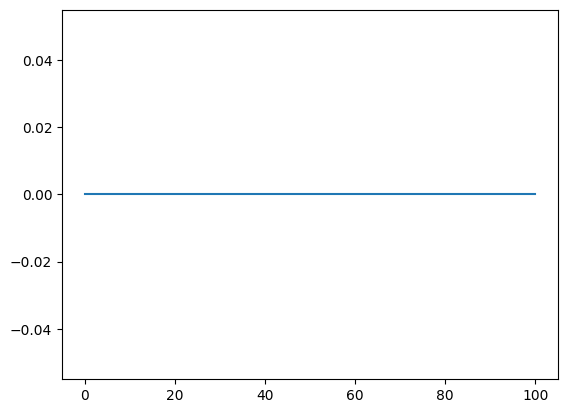

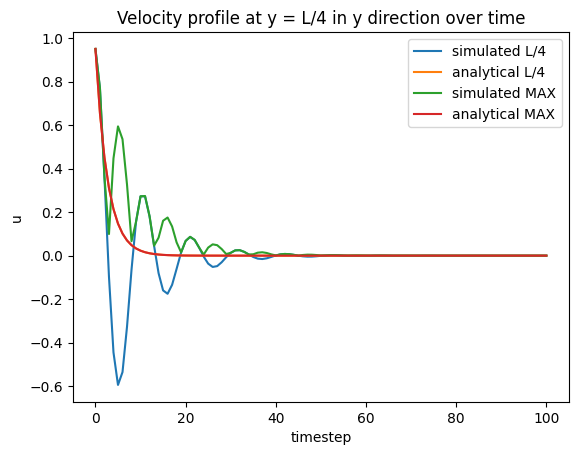

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


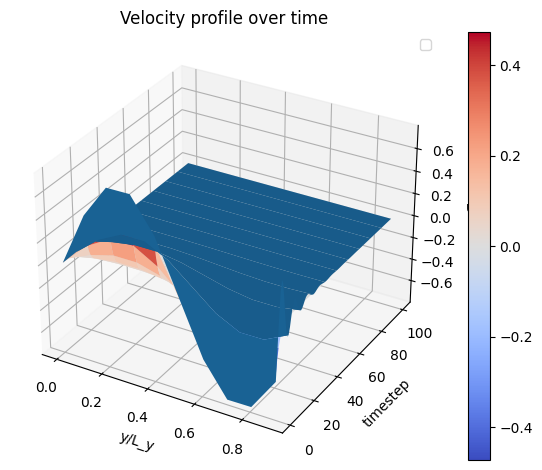

In [84]:
grid_size_x = 15
grid_size_y = 10
epsilon=0.01
omega = 0.3
timesteps = 100
rho0 = 1.

f_values_iyx, L =  shear_wave_initialization_2(grid_size_y, grid_size_x, rho0, epsilon=epsilon)

# calc initial density and average velocity field
density_values_yx, average_velocity_field_directions_yxc = calc_density_and_average_velocity(f_values_iyx)
# find index of first maximum of sinusoidal wave in y direction at t=0 and analytical solution for t=0
# input the average velocity field with only y component of cartesian coordinates (=last dimension 1)
# a0, index = find_amplitude_and_index(average_velocity_field_directions_yxc[:,:,1])
a0 = epsilon
# C stands here for component which means the direction in which the sinusoidal wave is moving, here in case of velocity the y direction
# c is cartesian coordinates (=xy)
analytical_solution_tC, simulated_solution_tyx = calc_analytical_and_simulated_solution(f_values_iyx, density_values_yx, average_velocity_field_directions_yxc, rho0, omega, L, timesteps, a0, plot=False)
# simulated_velocity_y_direction_at_index_t = simulated_solution_tyx[:, index[0], index[1], 1]
simulated_velocity_y_direction_at_index_t = np.amax(np.abs(simulated_solution_tyx[:, :, :, 1]), axis=(1,2))
analytical_velocity_at_index_t = np.amax(np.abs(analytical_solution_tC), axis=1)
# analytical_velocity_at_index_t = analytical_solution_tC[:, index[0]]

# x_axis = np.arange(0, timesteps + 1, 1)
# fig_velocity = plt.figure()
# ax_velocity_x = fig_velocity.add_subplot(111)
# ax_velocity_x.plot(x_axis, np.amax(np.abs(simulated_solution_tyx[:, :, :, 0]), axis=(1,2)), label="simulated x velocity")
# print(np.amax(np.abs(simulated_solution_tyx[:, :, :, 0]), axis=(0, 1,2)))

# plot analytical and simulated solution for velocity profile at one position over time
x_axis = np.arange(0, timesteps + 1, 1)
fig_velocity = plt.figure()
ax_velocity = fig_velocity.add_subplot(111)
ax_velocity.plot(x_axis, simulated_solution_tyx[:, int(L/4), 0, 1] / epsilon, label="simulated L/4")
ax_velocity.plot(x_axis, analytical_solution_tC[:, int(L/4)] / epsilon, label="analytical L/4")
ax_velocity.plot(x_axis, simulated_velocity_y_direction_at_index_t / epsilon, label="simulated MAX")
ax_velocity.plot(x_axis, analytical_velocity_at_index_t / epsilon, label="analytical MAX")
ax_velocity.set_xlabel("timestep")
ax_velocity.set_ylabel("u")
ax_velocity.set_title("Velocity profile at y = L/4 in y direction over time")
ax_velocity.legend()
plt.show()

# plot analytical and simulated solution for velocity profile at all positions over time
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_axis = np.arange(0, grid_size_y, 1) / grid_size_y
y_axis = np.arange(0, timesteps + 1, 1)
X, Y = np.meshgrid(x_axis, y_axis[1:])
# start plotting after first timestep to stop the plot to be filled at t=0
ax.plot_surface(X, Y, simulated_solution_tyx[1:,:,0,1] / epsilon, rstride=10, cstride=10)
color_plot = ax.plot_surface(X, Y, analytical_solution_tC[1:, :] / epsilon, cmap=cm.coolwarm, linewidth=0)
fig.colorbar(color_plot)
ax.set_xlabel("y/L_y")
ax.set_ylabel('timestep')
ax.set_zlabel("u")
ax.set_title("Velocity profile over time")
ax.legend()
fig.tight_layout()
plt.show()

#### Plot measured viscosity vs omega

In [ ]:
# # setup
# grid_size_x = 15
# grid_size_y = 10
# epsilon=0.01
# omega = 0.8
# timesteps = 100
# rho0 = 1.

# # u shape = (2, nx, ny)
# u = np.zeros((2, grid_size_x, grid_size_y))
# u[0] = epsilon * np.sin(2 * np.pi * np.arange(0, grid_size_x, 1) / grid_size_x)

# TODO: CHANGE U SHAPE IN OTHER CODE TO: (2, ny, nx)

# u = np.zeros((2, grid_size_y, grid_size_x))
# x = np.arange(grid_size_x)
# y = np.arange(grid_size_y)
# X, Y = np.meshgrid(x, y)

# u0 = 0.01
# k1 = 2 * np.pi / grid_size_y

# # also do experiment for different wave number: k2 = 2*k1
# u[0] = u0 * np.sin(k1 * Y)

Analytical prediction for viscosity in lattice units: 3.1666666666666665
Final predicted viscosity value: 0.09350546312094575
Viscosity from last maximum: 0.09096455623537066


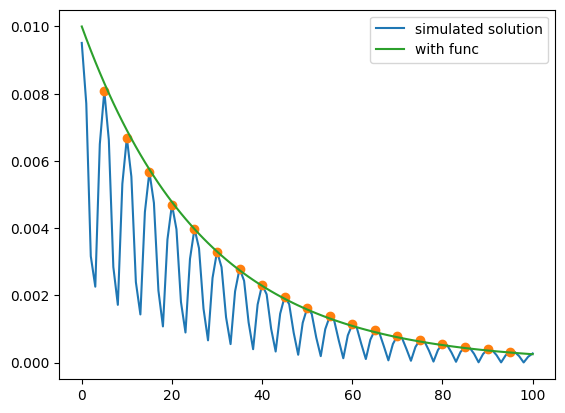

KeyboardInterrupt: 

In [67]:
# init omega list as values from 0.1 to 2 (exclusive) in 0.1 steps
omega_values = np.linspace(0.1, 2, 20)
simulated_viscositites = []
analytical_viscositites = []

grid_size_x = 15
grid_size_y = 10
epsilon=0.01
timesteps = 100
rho0 = 0.8
f_values_iyx = None
L = None
index = None
use_density_perturbation = False

for omega in omega_values:
    analytical_viscositites.append((1/3) * (1/omega - 0.5))
    
    if use_density_perturbation:
        f_values_iyx, L = shear_wave_initialization_1(grid_size_y, grid_size_x, rho0, epsilon=epsilon)
    else:
        # rho0 = 1.
        f_values_iyx, L =  shear_wave_initialization_2(grid_size_y, grid_size_x, rho0, epsilon=epsilon)
    
    density_values_yx, average_velocity_field_directions_yxc = calc_density_and_average_velocity(f_values_iyx)
   
    # if use_density_perturbation:
    #     a0, index = find_amplitude_and_index(density_values_yx - rho0)
    # else:
    #     a0, index = find_amplitude_and_index(average_velocity_field_directions_yxc[:,:,1])
    a0 = epsilon
    # L/4
    analytical_solution_tC, simulated_solution_tyx = calc_analytical_and_simulated_solution(f_values_iyx, density_values_yx, average_velocity_field_directions_yxc, rho0, omega, L, timesteps, a0, calc_density=use_density_perturbation)
    
    

    if use_density_perturbation:
        simulated_density_at_index_t = np.amax(np.abs(simulated_solution_tyx - rho0), axis=(1,2))
        # simulated_density_at_index_t = simulated_solution_tyx[:, index[0], index[1]]
        simulation_viscosity = calc_kinematic_viscosity(simulated_density_at_index_t, a0, L)
        simulated_viscositites.append(simulation_viscosity)
    else:
        # simulated_solution_tyx = simulated_solution_tyx[:, :int(L/4), :, :]
        # print(np.fft.fft(simulated_solution_tyx[0, :, 0, 1]))
        # check if other velocity component is zero (over 5 magnitudes smaller is also ok)
        # check if velocity magnitude smaller 0.1
        if simulated_solution_tyx[:, :, :, 0].any() > 1e-4:
            print("TOO LARGE VELOCITY IN X DIRECTION")
        if np.amax(simulated_solution_tyx[:, :, :, 1]) > 0.1:
            print("TOO LARGE VELOCITY MAGNITUDE IN Y DIRECTION")
            print(np.amax(simulated_solution_tyx[:, :, :, 1]))

        simulated_velocity_y_direction_at_index_t = np.amax(np.abs(simulated_solution_tyx[:,:,:,1]), axis=(1,2))
        # plt.plot(simulated_solution_tyx[:, index[0], index[1], 1])
        # plt.plot(np.amax(np.abs(simulated_solution_tyx[:,:,:,1]), axis=(1,2)))
        # simulated_velocity_y_direction_at_index_t = simulated_solution_tyx[:, index[0], index[1], 1]
        simulation_viscosity = calc_kinematic_viscosity(simulated_velocity_y_direction_at_index_t, a0, L)
        simulated_viscositites.append(simulation_viscosity)

print(analytical_viscositites)
print(simulated_viscositites)

title = "Analytical and simulated solution for viscosity from velocity decay"
if use_density_perturbation:
    title = "Analytical and simulated solution for viscosity from density decay"
plt.plot(omega_values, analytical_viscositites, label="analytical viscosity")
plt.plot(omega_values, simulated_viscositites, label="simulated viscosity")
plt.legend()
plt.xlabel("omega")
plt.ylabel("viscosity")
plt.title(title)